# Installation

In [ ]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install ipympl

# Imports

In [2]:
import tensorflow as tf
import cv2
# from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import keras
import pandas as pd
from pprint import pprint
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

2024-06-20 07:14:05.329422: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 07:14:05.329571: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 07:14:05.510157: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data

## Initializing Environment in Kaggle

In [ ]:
dataset_dir = '/kaggle/working'

In [6]:
!cp -r /kaggle/input/cloud-images-19510/ /kaggle/working/

In [41]:
!cp -r /kaggle/input/cloud-images-19510/ /kaggle/working/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [47]:
import os
import json

from kaggle_secrets import UserSecretsClient
secrets = UserSecretsClient()

os.environ['KAGGLE_USERNAME'] = secrets.get_secret("KAGGLE_USERNAME")
os.environ['KAGGLE_KEY'] = secrets.get_secret("KAGGLE_KEY")

!cp -r /kaggle/input/cloud-images-19510/ /kaggle/working/

meta = dict(
    id="ishansrivastava1308/Cloud-Images-19510",
    title="Cloud images Dataset",
    isPrivate=False,
    licenses=[dict(name="other")]
)

with open(os.path.join('/kaggle/working/cloud-images-19510','dataset-metadata.json'), 'w') as f:
    json.dump(meta, f)
    

!kaggle datasets version -m "Version 7 Classified Update" -p /kaggle/working/cloud-images-19510 --dir-mode tar

Starting upload for file Regression_model_e_10.keras
100%|██████████████████████████████████████| 52.8M/52.8M [00:03<00:00, 15.7MB/s]
Upload successful: Regression_model_e_10.keras (53MB)
Starting upload for file Train_Imputed.csv
100%|██████████████████████████████████████| 50.9M/50.9M [00:03<00:00, 16.0MB/s]
Upload successful: Train_Imputed.csv (51MB)
Starting upload for file train.csv
100%|██████████████████████████████████████| 47.1M/47.1M [00:03<00:00, 15.4MB/s]
Upload successful: train.csv (47MB)
Starting upload for file train_shell.csv
100%|██████████████████████████████████████| 58.0M/58.0M [00:03<00:00, 17.1MB/s]
Upload successful: train_shell.csv (58MB)
Starting upload for file Regression_model_e_20.keras
100%|██████████████████████████████████████| 52.8M/52.8M [00:03<00:00, 16.6MB/s]
Upload successful: Regression_model_e_20.keras (53MB)
Starting upload for file train_shell_remake.csv
100%|██████████████████████████████████████| 57.3M/57.3M [00:03<00:00, 16.6MB/s]
Upload succ

In [2]:
!cp -r /kaggle/input/cloud-images-19510/cloud-images-19510/train.csv /kaggle/working/

In [34]:
os.path.join('/kaggle/working/cloud-images-19510','dataset-metadata.json')

'/kaggle/working/cloud-images-19510/dataset-metadata.json'

In [25]:
import os
import json

from kaggle_secrets import UserSecretsClient
secrets = UserSecretsClient()

os.environ['KAGGLE_USERNAME'] = secrets.get_secret("KAGGLE_USERNAME")
os.environ['KAGGLE_KEY'] = secrets.get_secret("KAGGLE_KEY")

In [30]:



meta = dict(
    id="ishansrivastava1308/Cloud-Images-19510",
    title="Cloud images Dataset",
    isPrivate=False,
    licenses=[dict(name="other")]
)

with open(os.path.join('/kaggle/working/cloud-images-19510','dataset-metadata.json'), 'w') as f:
    json.dump(meta, f)


In [ ]:
# !kaggle datasets init

In [ ]:
# !kaggle datasets create -p {dataset_dir} --dir-mode zip

In [ ]:
!kaggle datasets version -m "Version 4  Update" -p /kaggle/working/ --dir-mode tar -d

Starting upload for file cloud-images-19510.tar
 38%|██████████████▋                        | 886M/2.30G [00:30<00:52, 29.1MB/s]

## Creating new Dataset Version

## Initializing Environment in Google Colab

In [ ]:
import os
import json

from google.colab import userdata

os.environ['KAGGLE_USERNAME'] = userdata.get("KAGGLE_USERNAME")
os.environ['KAGGLE_KEY'] = userdata.get("KAGGLE_KEY")

ModuleNotFoundError: No module named 'google.colab'

## Downloading Data in google colab

In [ ]:
!kaggle datasets download ishansrivastava1308/cloud-images-19510 -p /content/kaggle/input --force
!unzip /content/kaggle/input/cloud-images-19510.zip -d /content/kaggle/input/cloud-images-19510 && rm /content/kaggle/input/cloud-images-19510.zip


In [ ]:
# rm -r kaggle/input/

## Undistorting Images

In [ ]:
PWD = os.getcwd()
print(PWD)

/


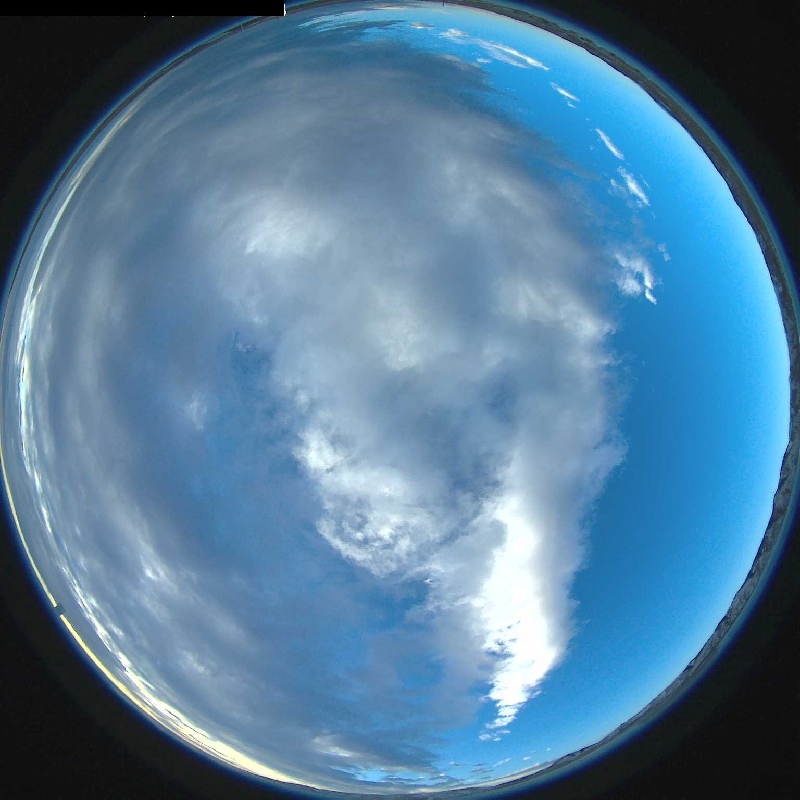

In [ ]:
img = tf.keras.utils.load_img(os.path.join(PWD,'kaggle/input/cloud-images-19510/0101/0101075000.jpg'), target_size = (800,800))
img

In [ ]:
def undistort(img_path, zoom_out_factor, balance, f, dist):
    dim = 2048
    DIM=(dim, dim)
    img = cv2.imread(img_path)

    K=np.array([
        [f, 0.0, 1536/2],
        [0.0, f, 1536/2],
        [0.0, 0.0, 1.0]])
    D=np.array([[dist],[dist],[dist],[dist]])


    dim1 = img.shape[:2][::-1]  #dim1 is the dimension of input image to un-distort
    new_K = np.array([
        [f / zoom_out_factor, 0.0, 1536/2],
        [0.0, f /zoom_out_factor, 1536/2],
        [0.0, 0.0, 1.0]])
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), new_K, dim1, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT)
    undistorted_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)
    return undistorted_img

In [ ]:
def undistort_func(img_path, zoom_out_factor, balance, f, dist):
    dim = 2048
    DIM=(dim, dim)
    img = cv2.imread(img_path)

    K=np.array([
        [f, 0.0, 1536/2],
        [0.0, f, 1536/2],
        [0.0, 0.0, 1.0]])
    D=np.array([[dist],[dist],[dist],[dist]])


    dim1 = img.shape[:2][::-1]  #dim1 is the dimension of input image to un-distort
    new_K = np.array([
        [f / zoom_out_factor, 0.0, 1536/2],
        [0.0, f /zoom_out_factor, 1536/2],
        [0.0, 0.0, 1.0]])
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), new_K, dim1, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT)
    undistorted_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)
    undistorted_img = cv2.resize(undistorted_img, (1000,1000))
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(undistorted_img)

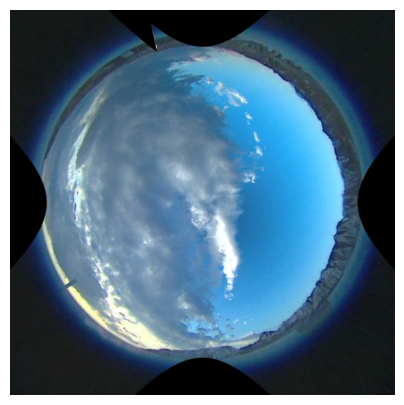

In [ ]:
undistort_func(os.path.join(PWD,'kaggle/input/cloud-images-19510/0101/0101075000.jpg'),5,1,250,0.025)

In [ ]:

import IPython
from IPython.display import display
from ipywidgets import interact, IntSlider, fixed, FloatSlider, IntRangeSlider

img = cv2.imread(os.path.join(PWD,'kaggle/input/cloud-images-19510/0101/0101075000.jpg'))

@interact(
    img=fixed(value = img),
    dist = FloatSlider(description = 'Dist'.ljust(15) + ':',  min = 0.,max = 1.,step = 0.001, readout_format = '0.3f'),
    f = (1,1000,1),
    zoom_out_factor = (1,200,1),
    balance = (0.,1.,0.1)
)
def undistorted_wrap(img,dist = 0.025, f = 400 ,zoom_out_factor = 2, balance=1.0,*args, **kwargs):
    dim = 2048
    DIM=(dim, dim)
#     img = cv2.imread(img_path)

    K=np.array([
        [f, 0.0, 1536/2],
        [0.0, f, 1536/2],
        [0.0, 0.0, 1.0]])
    D=np.array([[dist],[dist],[dist],[dist]])

    dim1 = img.shape[:2][::-1]  #dim1 is the dimension of input image to un-distort
    new_K = np.array([
        [f / zoom_out_factor, 0.0, 1536/2],
        [0.0, f /zoom_out_factor, 1536/2],
        [0.0, 0.0, 1.0]])
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), new_K, dim1, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT)
    undistorted_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)
    undistorted_img = cv2.resize(undistorted_img, (1000,1000))
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(undistorted_img)


interactive(children=(FloatSlider(value=0.0, description='Dist           :', max=1.0, readout_format='0.3f', s…

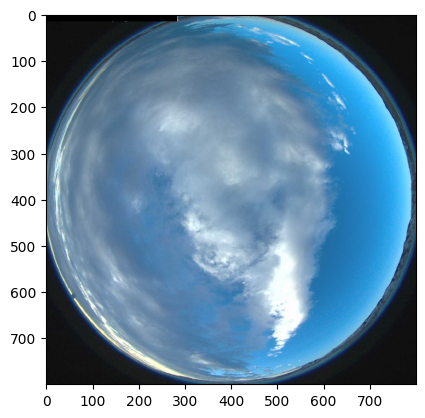

In [ ]:
plt.imshow(img)

In [ ]:

# img = cv2.imread(os.path.join(PWD,'/kaggle/input/cloud-images-19510/0101/0101100000.jpg'))
image = cv2.imread(os.path.join(PWD,'kaggle/input/cloud-images-19510/0101/0101080000.jpg'))

import IPython
from IPython.display import display
from ipywidgets import interact, IntSlider, fixed, FloatSlider, IntRangeSlider, interactive,interactive_output, HBox, VBox, Box, Layout

def undistorted_wrap_with_coeffs(img, f = 400 ,zoom_out_factor = 2, balance=1.0, k1 = 0.025, k2 = 0.025, k3 =0.025, k4 = 0.025, figsize = 1):
    dim = 2048
    DIM=(dim, dim)
#     img = cv2.imread(img_path)
    K=np.array([
        [f, 0.0, 1536/2],
        [0.0, f, 1536/2],
        [0.0, 0.0, 1.0]])
    D=np.array([[k1],[k2],[k3],[k4]])

    dim1 = img.shape[:2][::-1]  #dim1 is the dimension of input image to un-distort
    new_K = np.array([
        [f / zoom_out_factor, 0.0, 1536/2],
        [0.0, f /zoom_out_factor, 1536/2],
        [0.0, 0.0, 1.0]])
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), new_K, dim1, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT)
    undistorted_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)
    undistorted_img = cv2.resize(undistorted_img, (1000,1000))
    plt.figure(figsize=(figsize,figsize))
    plt.axis('off')
    plt.imshow(undistorted_img)


img                       = fixed(description = 'img'.ljust(15) + ':', value =  image)
f                         = IntSlider(description = 'f'.ljust(15) + ':',  min = 1,max = 1000, step = 1, value = 250)
zoom_out_factor           = IntSlider(description = 'zoom_out_factor'.ljust(15) + ':',  min = 1,max = 200,step = 1, value = 16)
balance                   = FloatSlider(description = 'balance'.ljust(15) + ':',  min = 0.,max = 1.,step = 0.1,value = 1)
k1                        = FloatSlider(description = 'k1'.ljust(15) + ':',  min = 0.,max = 1.,step = 0.001, value = 0.025, readout_format = '0.3f')
k2                        = FloatSlider(description = 'k2'.ljust(15) + ':',  min = 0.,max = 1.,step = 0.001, value = 0.025,readout_format = '0.3f')
k3                        = FloatSlider(description = 'k3'.ljust(15) + ':',  min = 0.,max = 1.,step = 0.001, value = 0.025,readout_format = '0.3f')
k4                        = FloatSlider(description = 'k4'.ljust(15) + ':',  min = 0.,max = 1.,step = 0.001, value = 0.025,readout_format = '0.3f')
figsize                   = IntSlider(description = 'figsize'.ljust(15) + ':',  min = 3, max = 15, step = 1, value = 9)


args = {
    'img' : img ,
    'f'  : f ,
    'zoom_out_factor'  : zoom_out_factor ,
    'balance'  : balance ,
    'k1'  : k1 ,
    'k2'  : k2 ,
    'k3'  : k3 ,
    'k4'  : k4 ,
    'figsize' : figsize ,
}

distort_widget = interactive_output(
    undistorted_wrap_with_coeffs,
    args
)



In [ ]:
sliders = list(args.values())

In [ ]:
HBox([VBox(children = sliders[1:]), distort_widget], layout = Layout(flex = 'flex-row'))

# Data Preprocessing

## Creating Tensorflow Datsets

In [ ]:
base_path = '/kaggle/input/cloud-images-19510'

In [ ]:
image_paths = [sorted([os.path.join(root,file) for file in files if file.endswith('.jpg')]) for root,dirs,files in os.walk(base_path) if len(dirs) == 0]

In [ ]:
flattened_image_paths = sorted([os.path.join(root,file) for root,dirs,files in os.walk(base_path) for file in files if not file.endswith('.csv')])

In [ ]:
len(flattened_image_paths)

23515

In [ ]:
def undistort_from_array(img, dim2 = None, dim3 = None, balance = 0):
    dim1 = img.shape[:2][::-1]  #dim1 is the dimension of input image to un-distort
    assert dim1[0]/dim1[1] == DIM[0]/DIM[1], "Image to undistort needs to have same aspect ratio as the ones used in calibration"
    if not dim2:
        dim2 = dim1
    if not dim3:
        dim3 = dim1
    scaled_K = K * dim1[0] / DIM[0]  # The values of K is to scale with image dimension.
    scaled_K[2][2] = 1.0  # Except that K[2][2] is always 1.0
    # This is how scaled_K, dim2 and balance are used to determine the final K used to un-distort image. OpenCV document failed to make this clear!
    new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(scaled_K, D, dim2, np.eye(3), balance=balance)
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(scaled_K, D, np.eye(3), new_K, dim3, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    undistorted_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)
    undistorted_img = cv2.resize(undistorted_img, (1000,1000))
    return undistorted_img


In [ ]:
import tensorflow as tf

class Preprocessor:
    def __init__(
            self,
            filepaths : list[str]
    ):
        self.filepaths = filepaths
        self.dataset = None

    def get_dataset_iterator(self,func):
        if self.dataset:
            return self.dataset
        self.dataset = tf.data.Dataset.from_tensor_slices(self.filepaths)
        self.dataset = self.dataset.map(func, num_parallel_calls=tf.data.AUTOTUNE)
        # self.dataset = self.dataset.cache()
        # self.dataset = self.dataset.shuffle(buffer_size=1000)
        # self.dataset = self.dataset.batch(32)
        # self.dataset = self.dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
        return self.dataset
@tf.function
def load_preprocess_y(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, [128, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image

@tf.function
def get_image_from_path(file_path):
    return image

@tf.py_function(Tout=tf.float64)
def get_undistorted_img(file_path):
    path_str = file_path.numpy().decode('utf-8')
    image = undistort(path_str,zoom_out_factor = 11,f = 282, dist = 0.015,balance = 1)
    return tf.convert_to_tensor(image,dtype = tf.float64)

In [ ]:
train_ds_x = Preprocessor(flattened_image_paths).get_dataset_iterator(get_undistorted_img)
# train_ds_x.map(get_undistorted_img)

In [ ]:
image_iter = train_ds_x.as_numpy_iterator()

In [ ]:
def show_grid_samples(ncols = 3,nrows = 3,scale = 1,**kwargs):
    figsize = (ncols * scale, nrows * scale)
    plt.tight_layout()
    fig,ax = plt.subplots(ncols = ncols, nrows = nrows, figsize = figsize)
    axes = ax.flatten()
    for a in axes:
        a.imshow(image_iter.next()/255, interpolation = 'nearest')
        a.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.show()

<Figure size 640x480 with 0 Axes>

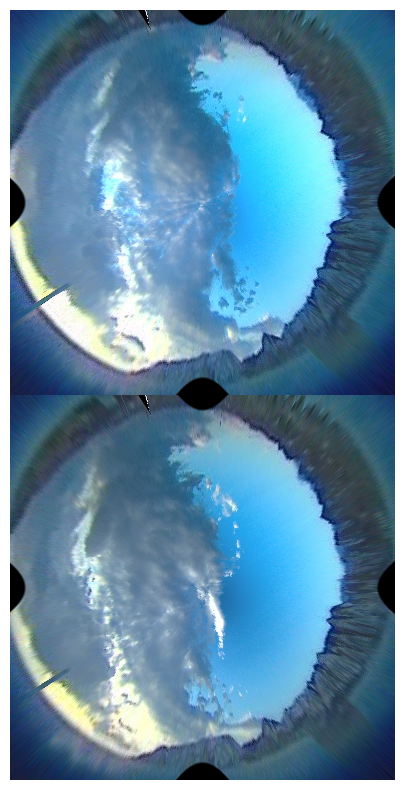

In [ ]:
show_grid_samples(ncols = 1,nrows = 2,scale = 5)

# Tabular Data

In [3]:
PWD =  os.getcwd()
print(PWD)

/


## Original Dataframe in "df"

In [4]:
df = pd.read_csv(os.path.join(PWD,'/kaggle/input/cloud-images-19510/train_shell_remake.csv' ))

In [5]:
df.columns

Index(['Unnamed: 0', 'DATE (MM/DD)', 'MST', 'Global CMP22 (vent/cor) [W/m^2]',
       'Direct sNIP [W/m^2]', 'Azimuth Angle [degrees]',
       'Tower Dry Bulb Temp [deg C]', 'Tower Wet Bulb Temp [deg C]',
       'Tower Dew Point Temp [deg C]', 'Tower RH [%]', 'Total Cloud Cover [%]',
       'Peak Wind Speed @ 6ft [m/s]', 'Avg Wind Direction @ 6ft [deg from N]',
       'Station Pressure [mBar]', 'Precipitation (Accumulated) [mm]',
       'Snow Depth [cm]', 'Moisture', 'Albedo (CMP11)'],
      dtype='object')

In [7]:
df[(df['DATE (MM/DD)'] == '01/05') & (df['MST'] >= '07:40')][0:40]

,Unnamed: 0,DATE (MM/DD),MST,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
6220,6220,01/05,07:40,31.2086,385.555,122.11761,-0.570,-3.419,-8.319,51.66,0.0,2.20,120.4,823.409,0.0,0.137,0.0,0.5072
6221,6221,01/05,07:41,33.2469,399.147,122.28130,-0.567,-3.447,-8.347,51.52,0.0,1.95,126.4,823.441,0.0,0.176,0.0,0.5014
6222,6222,01/05,07:42,35.2422,410.778,122.44531,-0.544,-3.469,-8.369,51.32,0.0,2.20,128.6,823.460,0.0,0.146,0.0,0.4961
6223,6223,01/05,07:43,37.3399,422.974,122.60963,-0.515,-3.469,-8.369,51.20,0.0,1.95,134.0,823.460,0.0,0.139,0.0,0.4913
6224,6224,01/05,07:44,39.4457,434.546,122.77426,-0.481,-3.379,-8.379,51.01,0.0,2.20,135.4,823.467,0.0,0.115,0.0,0.4858
6225,6225,01/05,07:45,41.4055,442.331,122.93921,-0.440,-3.340,-8.340,51.01,0.0,2.45,135.4,823.500,0.0,0.166,0.0,0.4774
6226,6226,01/05,07:46,43.5663,452.752,123.10448,-0.409,-3.322,-8.322,50.96,0.0,2.70,127.1,823.521,0.0,0.143,0.0,0.4701
6227,6227,01/05,07:47,45.9160,465.208,123.27008,-0.392,-3.357,-8.257,51.18,2.0,2.20,129.9,823.537,0.0,0.159,0.0,0.4625
6228,6228,01/05,07:48,48.1519,474.743,123.43599,-0.351,-3.272,-8.272,50.94,2.0,2.20,128.4,823.537,0.0,0.144,0.0,0.4537
6229,6229,01/05,07:49,50.3319,482.937,123.60223,-0.307,-3.329,-8.229,50.95,5.0,2.70,132.6,823.529,0.0,0.154,0.0,0.4464


## Removing NaN Values in "df_withoutNA"

In [14]:
df_withoutNA = df.dropna(how = 'any',ignore_index = True) # make the how to all later when imputation has happened for total_cloud_cover

## Getting Time data columns only after removing NaN in "df_time"

In [15]:
df_time = pd.DataFrame(df_withoutNA[['DATE (MM/DD)','MST']].to_numpy(),columns = ['DATE (MM/DD)','MST' ])

## Getting Numerical Data Columns in "df_num"

In [16]:
df_num = df_withoutNA[['Global CMP22 (vent/cor) [W/m^2]',
       'Direct sNIP [W/m^2]', 'Azimuth Angle [degrees]',
       'Tower Dry Bulb Temp [deg C]', 'Tower Wet Bulb Temp [deg C]',
       'Tower Dew Point Temp [deg C]', 'Tower RH [%]', 'Total Cloud Cover [%]',
       'Peak Wind Speed @ 6ft [m/s]', 'Avg Wind Direction @ 6ft [deg from N]',
       'Station Pressure [mBar]', 'Precipitation (Accumulated) [mm]',
       'Snow Depth [cm]', 'Moisture', 'Albedo (CMP11)']]


## Scaling Numerical Data in "df_scaled"

In [17]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_num), columns=df_num.columns)
df_scaled

,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
0,-0.688979,-0.652644,1.738910,-0.494915,-0.592721,-0.629683,-0.333307,-0.679668,3.524277,0.884943,-2.006732,-0.194002,0.016161,-0.25935,-0.715927
1,-0.688897,-0.652644,1.746763,-0.491605,-0.585145,-0.622575,-0.330397,-0.679668,2.658117,0.898690,-1.994857,-0.194002,0.016092,-0.25935,-0.715927
2,-0.688919,-0.652644,1.754622,-0.491132,-0.577424,-0.615330,-0.324576,-0.679668,1.915695,1.035303,-1.987849,-0.194002,0.015786,-0.25935,-0.715927
3,-0.688942,-0.652725,1.762485,-0.491321,-0.582232,-0.647180,-0.351601,-0.679668,2.410643,1.079982,-1.998167,-0.194002,0.016245,-0.25935,-0.715927
4,-0.688887,-0.652792,-1.769186,-0.484038,-0.579173,-0.644309,-0.356174,-0.679668,2.163169,1.006949,-2.010042,-0.194002,0.015965,-0.25935,-0.715927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480926,-0.689373,-0.649446,-1.765863,-1.864573,-1.893633,-0.920845,1.756723,-0.679668,-1.400459,-1.446074,-0.802314,-0.194002,0.029828,-0.25935,-0.715927
480927,-0.689439,-0.649513,-1.757968,-1.868545,-1.909658,-0.935881,1.735935,-0.679668,-1.053996,1.062798,-0.802119,-0.194002,0.029802,-0.25935,-0.715927
480928,-0.689491,-0.649580,-1.750077,-1.879233,-1.927868,-0.952968,1.731777,-0.679668,-1.400459,-1.446074,-0.804261,-0.194002,0.030024,-0.25935,-0.715927
480929,-0.689582,-0.649446,-1.742191,-1.884813,-1.930344,-0.955292,1.744250,-0.679668,-1.400459,-1.446074,-0.811074,-0.194002,0.030024,-0.25935,-0.715927


## Joining scaled data with time Data in "df_scaled_joined"

In [18]:
df_scaled_joined = pd.concat([df_time,df_scaled], axis = 1)

<Axes: >

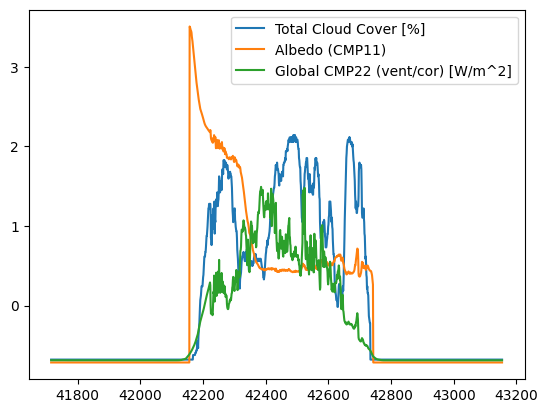

In [24]:
df_scaled_joined[df_scaled_joined['DATE (MM/DD)'] == '01/31'][['Total Cloud Cover [%]','Albedo (CMP11)','Global CMP22 (vent/cor) [W/m^2]']].iloc[0::1].plot()

## Getting daytime data indices in "day_idx"

In [19]:
# day_idx = df_time.loc[(df['MST'] >= '07:40') & (df['MST'] <= '16:15')].index.to_numpy()
day_idx = df_withoutNA.loc[(df['Total Cloud Cover [%]'] > 0)].index.to_numpy()

In [20]:
df_num

,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
0,-0.962276,0.000000,356.85640,7.216,0.988,-7.312,32.33,0.0,9.95,271.3,806.779,0.0,0.219,0.0,0.0
1,-0.937921,0.000000,357.65505,7.251,1.040,-7.260,32.40,0.0,8.20,272.9,806.840,0.0,0.206,0.0,0.0
2,-0.944395,0.000000,358.45438,7.256,1.093,-7.207,32.54,0.0,6.70,288.8,806.876,0.0,0.148,0.0,0.0
3,-0.951350,-0.029673,359.25416,7.254,1.060,-7.440,31.89,0.0,7.70,294.0,806.823,0.0,0.235,0.0,0.0
4,-0.934976,-0.054401,0.05415,7.331,1.081,-7.419,31.78,0.0,7.20,285.5,806.762,0.0,0.182,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480926,-1.078740,1.180110,0.39217,-7.266,-7.942,-9.442,82.60,0.0,0.00,0.0,812.966,0.0,2.805,0.0,0.0
480927,-1.098090,1.155420,1.19514,-7.308,-8.052,-9.552,82.10,0.0,0.70,292.0,812.967,0.0,2.800,0.0,0.0
480928,-1.113540,1.130740,1.99776,-7.421,-8.177,-9.677,82.00,0.0,0.00,0.0,812.956,0.0,2.842,0.0,0.0
480929,-1.140300,1.180120,2.79979,-7.480,-8.194,-9.694,82.30,0.0,0.00,0.0,812.921,0.0,2.842,0.0,0.0


In [21]:
df_scaled.loc[day_idx]

,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
467,-0.636663,-0.652430,-0.552070,-0.521680,-0.532264,-0.395250,-0.087592,-0.506956,-1.053996,0.360829,-2.928880,-0.194002,0.015172,-0.25935,0.366489
468,-0.629811,-0.652738,-0.550437,-0.534921,-0.548143,-0.396480,-0.073457,-0.449386,-1.053996,0.548994,-2.947179,-0.194002,0.015157,-0.25935,0.319886
469,-0.622706,-0.653060,-0.548801,-0.546175,-0.553096,-0.387458,-0.051005,-0.391815,-0.559047,0.821362,-2.948736,-0.194002,0.015918,-0.25935,0.273283
470,-0.615998,-0.653033,-0.547162,-0.548823,-0.546395,-0.381170,-0.041443,-0.305459,-0.311573,0.938213,-2.951267,-0.194002,0.015764,-0.25935,0.259413
471,-0.609778,-0.652859,-0.545520,-0.545986,-0.544938,-0.366133,-0.029386,-0.247889,-0.311573,0.559305,-2.970345,-0.194002,0.016880,-0.25935,0.263296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480490,-0.679150,-0.650771,0.595413,-1.727626,-1.676426,-0.676023,1.868978,-0.679668,-0.806521,-1.207903,-0.825674,-0.194002,0.030611,-0.25935,-0.715927
480491,-0.680256,-0.651185,0.596962,-1.729612,-1.679485,-0.678893,1.868978,-0.679668,-0.682784,-1.243732,-0.825674,-0.194002,0.030849,-0.25935,-0.715927
480492,-0.681380,-0.651721,0.598508,-1.731031,-1.683564,-0.682721,1.864821,-0.679668,-0.806521,-1.230500,-0.822949,-0.194002,0.030785,-0.25935,-0.715927
480493,-0.682028,-0.652189,0.600051,-1.731504,-1.684293,-0.683404,1.864821,-0.679668,-0.930258,-1.158671,-0.819640,-0.194002,0.030764,-0.25935,-0.715927


# Plots

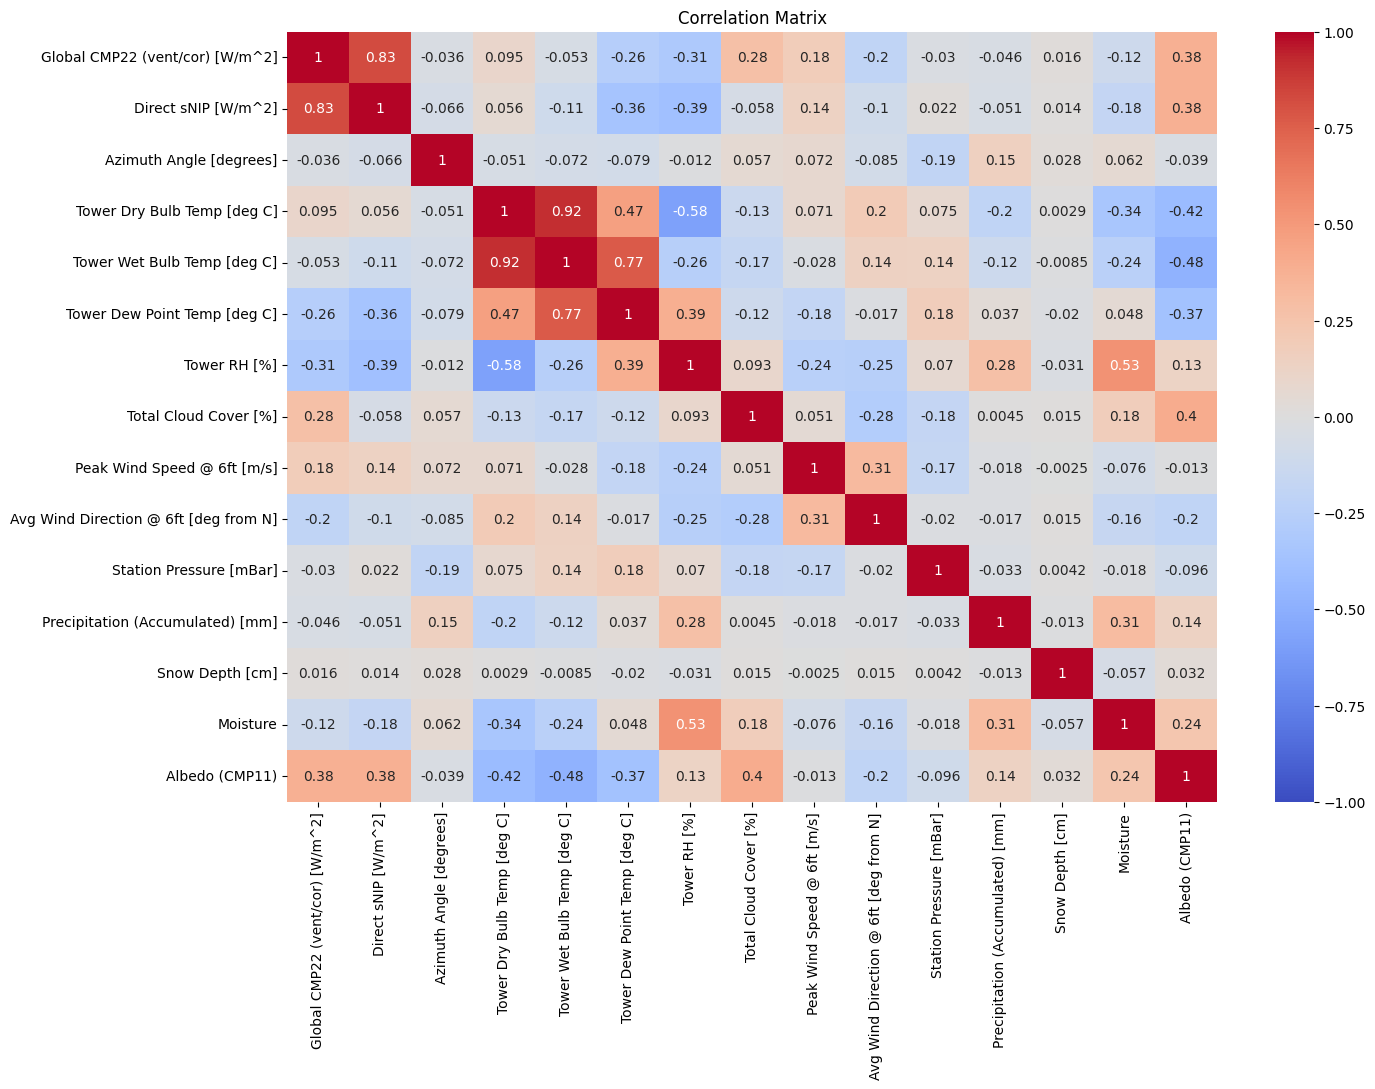

In [16]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_scaled.loc[day_idx].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


In [17]:
df.columns

Index(['Unnamed: 0', 'DATE (MM/DD)', 'MST', 'Global CMP22 (vent/cor) [W/m^2]',
       'Direct sNIP [W/m^2]', 'Azimuth Angle [degrees]',
       'Tower Dry Bulb Temp [deg C]', 'Tower Wet Bulb Temp [deg C]',
       'Tower Dew Point Temp [deg C]', 'Tower RH [%]', 'Total Cloud Cover [%]',
       'Peak Wind Speed @ 6ft [m/s]', 'Avg Wind Direction @ 6ft [deg from N]',
       'Station Pressure [mBar]', 'Precipitation (Accumulated) [mm]',
       'Snow Depth [cm]', 'Moisture', 'Albedo (CMP11)'],
      dtype='object')

<Axes: >

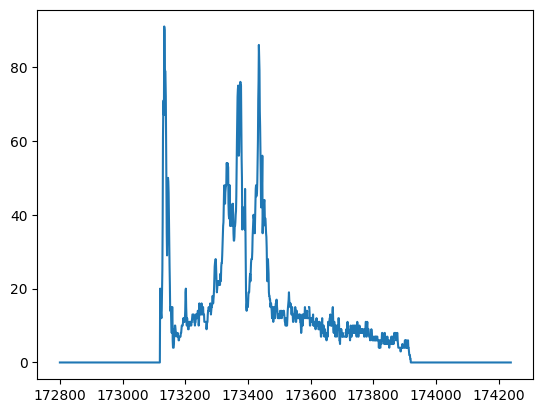

In [20]:
df[df['DATE (MM/DD)'] == '05/04']['Total Cloud Cover [%]'].plot()

In [148]:
global_intensity_vs_time = df_scaled_joined.loc[day_idx,['MST','Global CMP22 (vent/cor) [W/m^2]']][0:].groupby('MST').agg(['mean'])
global_intensity_vs_time = np.column_stack([global_intensity_vs_time.index.values, global_intensity_vs_time.to_numpy().reshape(-1)])
global_intensity_vs_time = dict(global_intensity_vs_time)

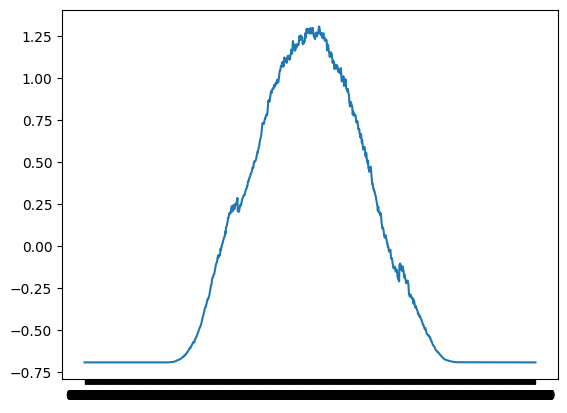

In [143]:
plt.plot(global_intensity_vs_time[0],global_intensity_vs_time[1])

### Cloud Cover vs Intensity

In [170]:
df_1Jan = df_scaled_joined.loc[day_idx].query('`DATE (MM/DD)` == "01-Jan" & `Total Cloud Cover [%]` > -0.669668')

In [171]:
df_1Jan

,DATE (MM/DD),MST,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
467,01-Jan,07:47,-0.636663,-0.652430,-0.552070,-0.521680,-0.532264,-0.395250,-0.087592,-0.506956,-1.053996,0.360829,-2.928880,-0.194002,0.015172,-0.25935,0.366489
468,01-Jan,07:48,-0.629811,-0.652738,-0.550437,-0.534921,-0.548143,-0.396480,-0.073457,-0.449386,-1.053996,0.548994,-2.947179,-0.194002,0.015157,-0.25935,0.319886
469,01-Jan,07:49,-0.622706,-0.653060,-0.548801,-0.546175,-0.553096,-0.387458,-0.051005,-0.391815,-0.559047,0.821362,-2.948736,-0.194002,0.015918,-0.25935,0.273283
470,01-Jan,07:50,-0.615998,-0.653033,-0.547162,-0.548823,-0.546395,-0.381170,-0.041443,-0.305459,-0.311573,0.938213,-2.951267,-0.194002,0.015764,-0.25935,0.259413
471,01-Jan,07:51,-0.609778,-0.652859,-0.545520,-0.545986,-0.544938,-0.366133,-0.029386,-0.247889,-0.311573,0.559305,-2.970345,-0.194002,0.016880,-0.25935,0.263296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971,01-Jan,16:14,-0.615443,-0.621401,0.540306,-0.501346,-0.645748,-0.802466,-0.468429,-0.650883,0.802061,1.165902,-2.861719,-0.194002,0.016404,-0.25935,-0.168339
972,01-Jan,16:15,-0.620908,-0.642190,0.541960,-0.521018,-0.663521,-0.791804,-0.442652,-0.650883,0.554587,1.086855,-2.861914,-0.194002,0.016235,-0.25935,-0.263764
973,01-Jan,16:16,-0.623458,-0.646626,0.543611,-0.533597,-0.669639,-0.811215,-0.446810,-0.650883,1.420746,1.126379,-2.867754,-0.194002,0.016716,-0.25935,-0.272641
974,01-Jan,16:17,-0.624052,-0.643101,0.545259,-0.539839,-0.685664,-0.812582,-0.442236,-0.650883,1.173272,1.089433,-2.866586,-0.194002,0.016800,-0.25935,-0.251559


In [172]:
def normalize_intensity(row, global_intensity_vs_time = global_intensity_vs_time):
    return row['Global CMP22 (vent/cor) [W/m^2]'] / global_intensity_vs_time[row['MST']]



In [173]:
normalised_intensities = df_1Jan.apply(normalize_intensity, axis = 1).to_numpy()

<Axes: ylabel='Total Cloud Cover [%]'>

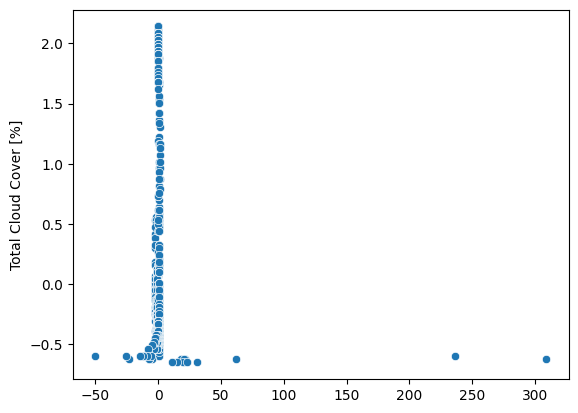

In [174]:
sns.scatterplot(x = normalised_intensities, y = df_1Jan['Total Cloud Cover [%]'])

In [112]:
df_scaled_joined.columns

Index(['DATE (MM/DD)', 'MST', 'Global CMP22 (vent/cor) [W/m^2]',
       'Direct sNIP [W/m^2]', 'Azimuth Angle [degrees]',
       'Tower Dry Bulb Temp [deg C]', 'Tower Wet Bulb Temp [deg C]',
       'Tower Dew Point Temp [deg C]', 'Tower RH [%]', 'Total Cloud Cover [%]',
       'Peak Wind Speed @ 6ft [m/s]', 'Avg Wind Direction @ 6ft [deg from N]',
       'Station Pressure [mBar]', 'Precipitation (Accumulated) [mm]',
       'Snow Depth [cm]', 'Moisture', 'Albedo (CMP11)'],
      dtype='object')

In [37]:
plt.figure(figsize = (15,3))
# sns.plot(
    
# )

sns.distplot(
    x = df_scaled_joined.loc[day_idx]['MST'][0:100],
    y = df_scaled_joined.loc[day_idx]['Total Cloud Cover [%]'][0:100], )

TypeError: distplot() got an unexpected keyword argument 'y'

<Figure size 1500x300 with 0 Axes>

In [ ]:
df.loc[(df['MST'] >= '07:40') & (df['DATE (MM/DD)'] == '01-Jan') ][0:50]

In [ ]:
df.loc[(df['MST'] == '07:40') & (df['DATE (MM/DD)'] == '01-Jan') ]

,DATE (MM/DD),MST,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
460,01-Jan,07:40,8.53993,1.0781,122.69154,7.202,1.503,-5.597,37.54,0.0,2.2,195.9,802.352,0.0,0.07,0.0,0.1883


In [167]:
df1

,DATE (MM/DD),MST,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
0,01/01,00:00,-0.962276,0.000000,356.85640,7.216,0.988,-7.312,32.33,0.0,9.95,271.3,806.779,0.0,0.219,0.0,0.0
1,01/01,00:01,-0.937921,0.000000,357.65505,7.251,1.040,-7.260,32.40,0.0,8.20,272.9,806.840,0.0,0.206,0.0,0.0
2,01/01,00:02,-0.944395,0.000000,358.45438,7.256,1.093,-7.207,32.54,0.0,6.70,288.8,806.876,0.0,0.148,0.0,0.0
3,01/01,00:03,-0.951350,-0.029673,359.25416,7.254,1.060,-7.440,31.89,0.0,7.70,294.0,806.823,0.0,0.235,0.0,0.0
4,01/01,00:04,-0.934976,-0.054401,0.05415,7.331,1.081,-7.419,31.78,0.0,7.20,285.5,806.762,0.0,0.182,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498235,12/11,23:55,-1.078740,1.180110,0.39217,-7.266,-7.942,-9.442,82.60,0.0,0.00,0.0,812.966,0.0,2.805,0.0,0.0
498236,12/11,23:56,-1.098090,1.155420,1.19514,-7.308,-8.052,-9.552,82.10,0.0,0.70,292.0,812.967,0.0,2.800,0.0,0.0
498237,12/11,23:57,-1.113540,1.130740,1.99776,-7.421,-8.177,-9.677,82.00,0.0,0.00,0.0,812.956,0.0,2.842,0.0,0.0
498238,12/11,23:58,-1.140300,1.180120,2.79979,-7.480,-8.194,-9.694,82.30,0.0,0.00,0.0,812.921,0.0,2.842,0.0,0.0


In [177]:
df1.to_csv('/kaggle/working/cloud-images-19510/train_shell_remake.csv')

In [178]:
df1.isna().sum()

DATE (MM/DD)                                0
MST                                         0
Global CMP22 (vent/cor) [W/m^2]             0
Direct sNIP [W/m^2]                         0
Azimuth Angle [degrees]                     0
Tower Dry Bulb Temp [deg C]                 0
Tower Wet Bulb Temp [deg C]                 0
Tower Dew Point Temp [deg C]                0
Tower RH [%]                                0
Total Cloud Cover [%]                    1469
Peak Wind Speed @ 6ft [m/s]                 0
Avg Wind Direction @ 6ft [deg from N]       0
Station Pressure [mBar]                     0
Precipitation (Accumulated) [mm]            0
Snow Depth [cm]                             0
Moisture                                    0
Albedo (CMP11)                              0
dtype: int64

In [176]:
df1 = df1.reset_index(drop=True)

In [170]:
train = pd.read_csv('/kaggle/working/cloud-images-19510/train_shell.csv')

In [171]:
train

,DATE (MM/DD),MST,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
0,1/1,00:00,-0.962276,0.000000,356.85640,7.216,0.988,-7.312,32.33,-1,9.95,271.3,806.779,0.0,0.219,0.0,0.0
1,1/1,00:01,-0.937921,0.000000,357.65505,7.251,1.040,-7.260,32.40,-1,8.20,272.9,806.840,0.0,0.206,0.0,0.0
2,1/1,00:02,-0.944395,0.000000,358.45438,7.256,1.093,-7.207,32.54,-1,6.70,288.8,806.876,0.0,0.148,0.0,0.0
3,1/1,00:03,-0.951350,-0.029673,359.25416,7.254,1.060,-7.440,31.89,-1,7.70,294.0,806.823,0.0,0.235,0.0,0.0
4,1/1,00:04,-0.934976,-0.054401,0.05415,7.331,1.081,-7.419,31.78,-1,7.20,285.5,806.762,0.0,0.182,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527035,12/31,23:55,-1.360910,-0.340704,352.62902,-0.469,-3.940,-10.140,43.61,-1,0.00,0.0,816.186,0.0,2.899,0.0,0.0
527036,12/31,23:56,-1.342520,-0.325891,353.41779,-0.499,-3.927,-10.127,43.77,-1,0.00,0.0,816.185,0.0,2.866,0.0,0.0
527037,12/31,23:57,-1.341260,-0.320952,354.20842,-0.522,-3.958,-10.158,43.73,-1,0.00,0.0,816.198,0.0,2.882,0.0,0.0
527038,12/31,23:58,-1.334130,-0.320953,355.00071,-0.558,-3.979,-10.079,44.17,-1,0.00,0.0,816.194,0.0,2.805,0.0,0.0


In [33]:
df.columns

Index(['Unnamed: 0', 'DATE (MM/DD)', 'MST', 'Global CMP22 (vent/cor) [W/m^2]',
       'Direct sNIP [W/m^2]', 'Azimuth Angle [degrees]',
       'Tower Dry Bulb Temp [deg C]', 'Tower Wet Bulb Temp [deg C]',
       'Tower Dew Point Temp [deg C]', 'Tower RH [%]', 'Total Cloud Cover [%]',
       'Peak Wind Speed @ 6ft [m/s]', 'Avg Wind Direction @ 6ft [deg from N]',
       'Station Pressure [mBar]', 'Precipitation (Accumulated) [mm]',
       'Snow Depth [cm]', 'Moisture', 'Albedo (CMP11)'],
      dtype='object')

# Model Workshop

In [2]:
train = df.dropna()

NameError: name 'df' is not defined

In [ ]:
train = df[df['Total Cloud Cover [%]'] > 0]

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
time_encoder = OrdinalEncoder().fit(train[['MST']].to_numpy())
train.loc[:,'MST'] = time_encoder.transform(train[['MST']].to_numpy()).reshape(-1)


In [ ]:
train_x_df = train[['MST','Global CMP22 (vent/cor) [W/m^2]',
       'Direct sNIP [W/m^2]', 'Azimuth Angle [degrees]',
       'Tower Dry Bulb Temp [deg C]', 'Tower Wet Bulb Temp [deg C]',
       'Tower Dew Point Temp [deg C]', 'Tower RH [%]',
       'Peak Wind Speed @ 6ft [m/s]', 'Avg Wind Direction @ 6ft [deg from N]',
       'Station Pressure [mBar]', 'Precipitation (Accumulated) [mm]',
       'Snow Depth [cm]', 'Moisture', 'Albedo (CMP11)']]

In [ ]:
train_y_df = train[['Total Cloud Cover [%]']]

In [29]:
train_x = train_x_df.to_numpy()
train_y = train_y_df.to_numpy()

In [30]:
scalerx = StandardScaler()
scalery = StandardScaler()

In [31]:
scalerx.fit(train_x)
train_x_scaled = scalerx.transform(train_x)
# scalery.fit(train_y)
# train_y_scaled = scalery.transform(train_y)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(train_x_scaled, train_y, test_size=0.05, random_state=42)

In [22]:
validation_data = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(32)

In [26]:
validation_data.as_numpy_iterator().next()[0].shape

(32, 15)

In [27]:
X_trainargpartition.shape

NameError: name 'X_trainargpartition' is not defined

In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (15,)),
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(1,activation = 'linear'),
])

In [35]:
model.compile(optimizer='adam',
loss=tf.keras.losses.MeanSquaredError(),
metrics=[
    tf.keras.metrics.R2Score(), 
    tf.keras.metrics.MeanAbsoluteError(),
    tf.keras.metrics.MeanAbsoluteError(),
    tf.keras.metrics.MeanAbsolutePercentageError(),
])


In [36]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,609,537 (17.58 MB)

 Trainable params: 4,609,537 (17.58 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model.fit(x = X_train, y = y_train, epochs = 10, validation_data = validation_data)

Epoch 1/10
6907/6907 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 43.6621 - mean_absolute_error: 4.1419 - mean_absolute_error_1: 4.1419 - mean_absolute_percentage_error: 18.0015 - r2_score: 0.9655 - val_loss: 47.5457 - val_mean_absolute_error: 4.3682 - val_mean_absolute_error_1: 4.3682 - val_mean_absolute_percentage_error: 19.1331 - val_r2_score: 0.9628
Epoch 2/10
6907/6907 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 47.3576 - mean_absolute_error: 4.2938 - mean_absolute_error_1: 4.2938 - mean_absolute_percentage_error: 18.7928 - r2_score: 0.9625 - val_loss: 39.2547 - val_mean_absolute_error: 4.0583 - val_mean_absolute_error_1: 4.0583 - val_mean_absolute_percentage_error: 18.5135 - val_r2_score: 0.9693
Epoch 3/10
6907/6907 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 46.0994 - mean_absolute_error: 4.1231 - mean_absolute_error_1: 4.1231 - mean_absolute_percentage_error: 18.4329 - r2_score: 0.9636 - val_loss: 51.1581 - val_mean_absolute_error: 4.4489 - val_mean_absolute_error_1: 4.4489 - val_mean

In [40]:
model.save('Regression_model_e_20.keras')

(array([37257., 46049., 20425., 12667., 10799., 10280., 10901., 12854.,
        17456., 53968.]),
 array([  1. ,  10.9,  20.8,  30.7,  40.6,  50.5,  60.4,  70.3,  80.2,
         90.1, 100. ]),
 <BarContainer object of 10 artists>)

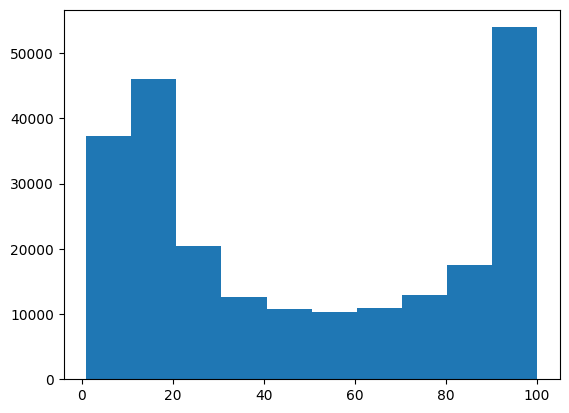

In [51]:
plt.hist(train['Total Cloud Cover [%]'])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

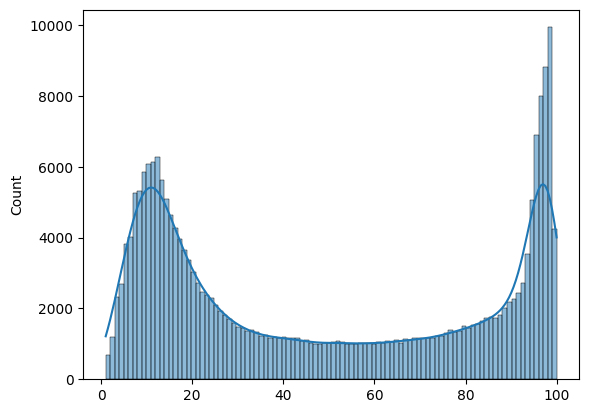

In [54]:
sns.histplot(train['Total Cloud Cover [%]'].to_numpy(), bins=100, kde=True)

In [59]:
predictions = model.predict(train_x_scaled)

 115/7271 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step 

W0000 00:00:1718740810.346366     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7271/7271 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


W0000 00:00:1718740820.466472     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: ylabel='Count'>

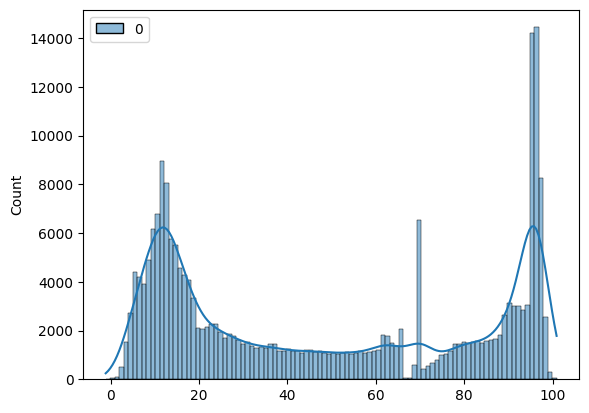

In [60]:
sns.histplot(predictions, bins=100, kde=True)

In [62]:
train_x_scaled

array([[-1.21898225, -1.35183039, -1.25399925, ...,  0.01356949,
        -0.2453778 , -0.36200646],
       [-1.2142114 , -1.34506716, -1.25428756, ...,  0.01355263,
        -0.2453778 , -0.41072041],
       [-1.20944055, -1.33805335, -1.25458841, ...,  0.01436223,
        -0.2453778 , -0.45943437],
       ...,
       [ 1.19029699, -1.32983978, -1.2529232 , ...,  0.02991341,
        -0.2453778 ,  2.3549563 ],
       [ 1.19506784, -1.33418645, -1.25286063, ...,  0.02972787,
        -0.2453778 ,  2.3798932 ],
       [ 1.19983869, -1.33689602, -1.25286063, ...,  0.02958732,
        -0.2453778 ,  2.38975198]])

In [66]:
evaluation = model.evaluate(x = train_x_scaled, y = train_y, return_dict = True)

7271/7271 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 36.1387 - mean_absolute_error: 3.5663 - mean_absolute_error_1: 3.5663 - mean_absolute_percentage_error: 19.9920 - r2_score: 0.9715


In [67]:
evaluation

{'loss': 32.81338119506836,
 'mean_absolute_error': 3.553403377532959,
 'mean_absolute_error_1': 3.553403377532959,
 'mean_absolute_percentage_error': 16.19646453857422,
 'r2_score': 0.9740592837333679}

In [16]:
model = tf.keras.models.load_model('/kaggle/input/cloud-images-19510/Regression_model_e_20.keras')

In [17]:
evaluation = model.evaluate(x = train_x_scaled, y = train_y, return_dict = True)

  10/7271 ━━━━━━━━━━━━━━━━━━━━ 1:31 13ms/step - loss: 26.9454 - mean_absolute_error: 3.7224 - mean_absolute_error_1: 3.7224 - mean_absolute_percentage_error: 19.2830 - r2_score: 0.9023

I0000 00:00:1718773813.133354     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-06-19 05:10:13.135739: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


7271/7271 ━━━━━━━━━━━━━━━━━━━━ 95s 13ms/step - loss: 36.1387 - mean_absolute_error: 3.5663 - mean_absolute_error_1: 3.5663 - mean_absolute_percentage_error: 19.9920 - r2_score: 0.9715


In [19]:
predictions = model.predict(train_x_scaled)

7271/7271 ━━━━━━━━━━━━━━━━━━━━ 93s 13ms/step


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: ylabel='Count'>

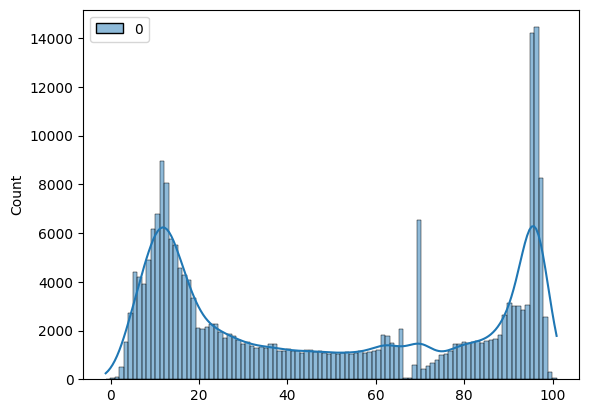

In [20]:
sns.histplot(predictions, bins=100, kde=True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: ylabel='Count'>

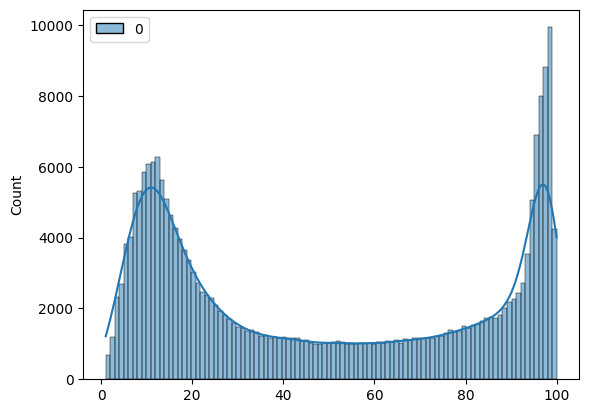

In [21]:
sns.histplot(train_y, bins=100, kde=True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: ylabel='Count'>

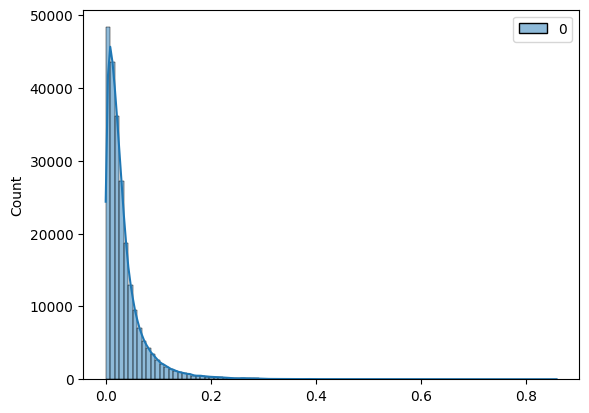

In [35]:
sns.histplot(np.abs(train_y - predictions) / 100,  bins=100, kde=True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


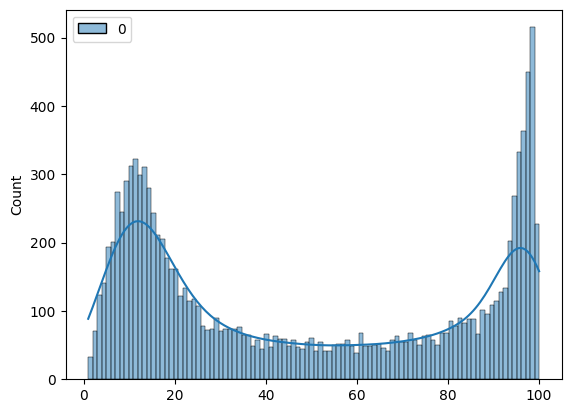

In [36]:
sns.histplot(y_test,  bins=100, kde=True)

In [37]:
val_pred = model.predict(X_test)

364/364 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: ylabel='Count'>

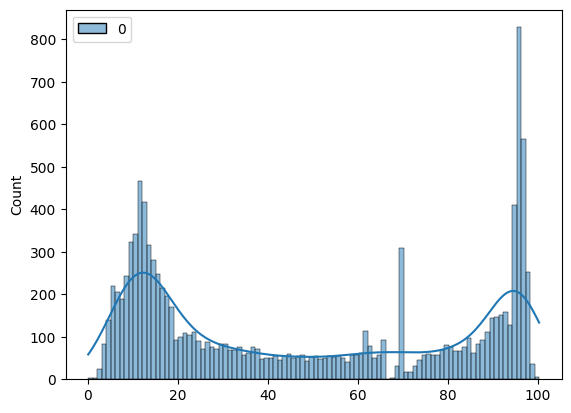

In [38]:
sns.histplot(val_pred,  bins=100, kde=True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: ylabel='Count'>

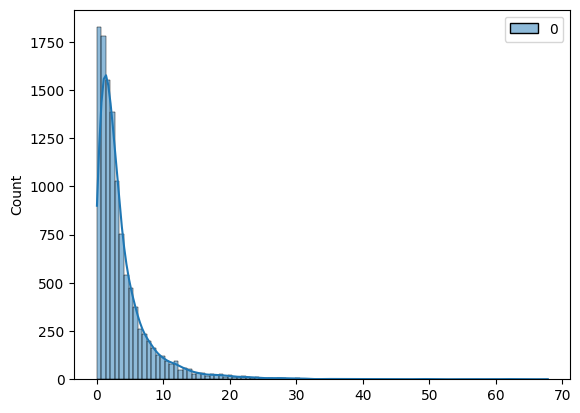

In [39]:
sns.histplot(np.abs(val_pred - y_test),  bins=100, kde=True)

In [47]:
high_error_idx = np.abs(val_pred - y_test) > 10

In [48]:
high_error_idx.sum()/ high_error_idx.shape[0]

0.0721224103842517

In [ ]:
01-Feb -> 01/02
Jan-13 -> 01/13

In [5]:
df

,DATE (MM/DD),MST,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
0,01/01,00:00,-0.962276,0.000000,356.85640,7.216,0.988,-7.312,32.33,0.0,9.95,271.3,806.779,0.0,0.219,0.0,0.0
1,01/01,00:01,-0.937921,0.000000,357.65505,7.251,1.040,-7.260,32.40,0.0,8.20,272.9,806.840,0.0,0.206,0.0,0.0
2,01/01,00:02,-0.944395,0.000000,358.45438,7.256,1.093,-7.207,32.54,0.0,6.70,288.8,806.876,0.0,0.148,0.0,0.0
3,01/01,00:03,-0.951350,-0.029673,359.25416,7.254,1.060,-7.440,31.89,0.0,7.70,294.0,806.823,0.0,0.235,0.0,0.0
4,01/01,00:04,-0.934976,-0.054401,0.05415,7.331,1.081,-7.419,31.78,0.0,7.20,285.5,806.762,0.0,0.182,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482395,12/11,23:55,-1.078740,1.180110,0.39217,-7.266,-7.942,-9.442,82.60,0.0,0.00,0.0,812.966,0.0,2.805,0.0,0.0
482396,12/11,23:56,-1.098090,1.155420,1.19514,-7.308,-8.052,-9.552,82.10,0.0,0.70,292.0,812.967,0.0,2.800,0.0,0.0
482397,12/11,23:57,-1.113540,1.130740,1.99776,-7.421,-8.177,-9.677,82.00,0.0,0.00,0.0,812.956,0.0,2.842,0.0,0.0
482398,12/11,23:58,-1.140300,1.180120,2.79979,-7.480,-8.194,-9.694,82.30,0.0,0.00,0.0,812.921,0.0,2.842,0.0,0.0


# Sequence Modelling

In [3]:
df = pd.read_csv('/kaggle/input/cloud-images-19510/train_shell_remake_imputed.csv')

In [3]:
train = df.dropna()

In [4]:
# train = df[df['Total Cloud Cover [%]'] > 0]

In [5]:
from sklearn.preprocessing import OrdinalEncoder
time_encoder = OrdinalEncoder().fit(train[['MST']].to_numpy())
train.loc[:,'MST'] = time_encoder.transform(train[['MST']].to_numpy()).reshape(-1)


In [6]:
scalerx = StandardScaler()
scalery = StandardScaler()

In [7]:
train.columns

Index(['Unnamed: 0', 'DATE (MM/DD)', 'MST', 'Global CMP22 (vent/cor) [W/m^2]',
       'Direct sNIP [W/m^2]', 'Azimuth Angle [degrees]',
       'Tower Dry Bulb Temp [deg C]', 'Tower Wet Bulb Temp [deg C]',
       'Tower Dew Point Temp [deg C]', 'Tower RH [%]', 'Total Cloud Cover [%]',
       'Peak Wind Speed @ 6ft [m/s]', 'Avg Wind Direction @ 6ft [deg from N]',
       'Station Pressure [mBar]', 'Precipitation (Accumulated) [mm]',
       'Snow Depth [cm]', 'Moisture', 'Albedo (CMP11)'],
      dtype='object')

In [8]:
days = train.iloc[:,1].unique()

In [9]:
train_x_df = train[
    ['MST', 'Global CMP22 (vent/cor) [W/m^2]',
       'Direct sNIP [W/m^2]', 'Azimuth Angle [degrees]',
       'Tower Dry Bulb Temp [deg C]', 'Tower Wet Bulb Temp [deg C]',
       'Tower Dew Point Temp [deg C]', 'Tower RH [%]',
       'Peak Wind Speed @ 6ft [m/s]', 'Avg Wind Direction @ 6ft [deg from N]',
       'Station Pressure [mBar]', 'Precipitation (Accumulated) [mm]',
       'Snow Depth [cm]', 'Moisture', 'Albedo (CMP11)']
].astype(np.float64)

In [10]:
train_x_df.loc[:,:] = scalerx.fit_transform(train_x_df)

In [11]:
train_y_df = train[['Total Cloud Cover [%]']].astype(np.float64)

In [12]:
train_y_df.loc[:,:] = scalery.fit_transform(train_y_df)

In [13]:
train_x_df.loc[:,['Total Cloud Cover [%]']] = train_y_df.loc[:,['Total Cloud Cover [%]']]

In [14]:
input_size = 6 * 60 / 2

In [15]:
def sequenceBatcher(dataX : np.ndarray, dataY : np.ndarray, input_size : int, future_timestamp : int, gap : int = 1):
    dataX = dataX[::gap]
    dataY = dataY[::gap]
    data_size = dataX.shape[0]
    input_size = int(input_size)
    extent_size = int(input_size + future_timestamp)
    
    assert data_size == dataY.shape[0]
    
    batchX = np.array(
        [
            dataX[i : i + input_size] 
            for i in range(0, data_size - extent_size)
        ]
    )
    batchY = np.array(
        [
            dataY[i + extent_size]
            for i in range(0, data_size - extent_size)
        ]
    )
    return batchX, batchY
    



In [16]:
def get_sequences_of_listed_days(day_list, data_df, input_size = 360):
        batchX, batchY = [],[]
        
        [
            (batchX.extend(x), batchY.extend(y)) for x, y in [
                sequenceBatcher(
                    train_x_df.loc[data_df['DATE (MM/DD)'] == days].to_numpy(),
                    train_y_df.loc[data_df['DATE (MM/DD)'] == days].to_numpy(),
                    input_size,
                    15,
                    2,
                ) for days in day_list
            ]
        ]
        return np.array(batchX), np.array(batchY)
                               

# Creating tensorflow datasets

In [ ]:
3 x 3 / 128 x128  

In [17]:
X_train, X_val, y_train, y_val = train_test_split(*get_sequences_of_listed_days(days, train, input_size),test_size = 0.05, shuffle = False)

In [18]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(32)

In [19]:
X_train.shape

(166459, 180, 16)

# Saving Models to Kaggle Database

## Secret and Directory Initialization

In [6]:
dir_to_new_model = '/kaggle/working/models'
import os
import json

from kaggle_secrets import UserSecretsClient
secrets = UserSecretsClient()

os.environ['KAGGLE_USERNAME'] = secrets.get_secret("KAGGLE_USERNAME")
os.environ['KAGGLE_KEY'] = secrets.get_secret("KAGGLE_KEY")

os.makedirs('/kaggle/working/models', exist_ok = True)

## Creating Kaggle Models

In [102]:


model_meta_data = {
  "ownerSlug": "ishansrivastava1308",
  "title": "CloudCover AI",
  "slug": "ccd-ai",
  "subtitle": "",
  "isPrivate": False,
  "description": "# Model Summary\n\n# Model Characteristics\n\n# Data Overview\n\n# Evaluation Results\n",
  "publishTime": "",
  "provenanceSources": ""
}

with open(os.path.join(dir_to_new_model,'model-metadata.json'), 'w') as f:
    json.dump(model_meta_data, f)
    

In [103]:
#  !kaggle models create --path /kaggle/working/models

Your model was created. Id=77046. Url=https://www.kaggle.com/models/ishansrivastava1308/ccd-ai


## Creating Model instance

In [54]:
model_instance_meta_data = {
  "ownerSlug": "ishansrivastava1308",
  "modelSlug": "ccd-ai",
  "instanceSlug": "LSTM-series-B",
  "framework": "keras",
  "overview": "",
  "usage": "# Model Format\n\n# Training Data\n\n# Model Inputs\n\n# Model Outputs\n\n# Model Usage\n\n# Fine-tuning\n\n# Changelog\n",
  "licenseName": "Apache 2.0",
  "fineTunable": True,
  "trainingData": [],
  "modelInstanceType": "Unspecified",
  "baseModelInstanceId": 0,
  "externalBaseModelUrl": ""
}

with open(os.path.join('/kaggle/working/models','model-instance-metadata.json'), 'w') as f:
    json.dump(model_instance_meta_data, f)
    

In [55]:
!kaggle models instances create -p /kaggle/working/models --dir-mode tar

Starting upload for file LSTM_series_B_base.keras
100%|██████████████████████████████████████| 5.44M/5.44M [00:00<00:00, 7.86MB/s]
Upload successful: LSTM_series_B_base.keras (5MB)
Your model instance was created. Id=56052. Url=https://www.kaggle.com/models/ishansrivastava1308/ccd-ai/Keras/lstm-series-b


## Creating model versions

In [38]:
!kaggle models instances versions create ishansrivastava1308/ccd-ai/keras/LSTM-series-B -p /kaggle/working/models --dir-mode tar

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Starting upload for file LSTM_series_A_5.keras
100%|██████████████████████████████████████| 16.2M/16.2M [00:00<00:00, 20.9MB/s]
Upload successful: LSTM_series_A_5.keras (16MB)
Starting upload for file logs.tar
100%|██████████████████████████████████████| 1.04M/1.04M [00:00<00:00, 1.80MB/s]
Upload successful: logs.tar (1MB)
Starting upload for file LSTM_series_A_10.keras
100%|██████████████████████████████████████| 16.2M/16.2M [00:00<00:00, 22.9MB/s]
Upload successful: LSTM_series_A_10.keras (16MB)
Starting upload for file LSTM_series_A_15.keras
100%|██████████████████████████████████████| 16.2M/16.2M [00:00<00:00, 20.3MB/s]
Upload successful: LSTM_series_A_15.keras (16MB)
Your model instance version was created. Url=https://www.kaggle.com/models/ishansrivastava1308/ccd-ai/Keras/LSTM-series-B/3


# Metrics and Callbacks

## Callbacks

In [27]:
class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print()
        val = {}
        train = defaultdict(lambda: "None")
        for k,v in logs.items():
            if k.startswith('val_'):
                val[k[4:]] = v
            else:
                train[k] = [v, "None"]
        # print(val, train)

        for k,v in val.items():
            if train[k] != "None":
                train[k][1] = v
            else:
                train[k] = ["None", v]

        print("+","-"*128,"+",sep = "")
        print("| {:<40} | {:<40} | {:<40} |".format("Metrics","Train","Val"))
        print("+","-"*128,"+",sep = "")
        for k,v in train.items():
            print("| {:<40} | {:<40} | {:<40} |".format(k, v[0], v[1]))
        print("+","-"*128,"+",sep = "")
        print()



In [28]:
class SaveModelOnEpoch(tf.keras.callbacks.Callback):
    def __init__(self, save_path,freq = 5,offset = 0):
        super(SaveModelOnEpoch, self).__init__()
        self.save_path = save_path
        self.freq = freq
        self.offset = offset

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.freq == 0:  # Save every 5 epochs
            self.model.save(self.save_path.format(epoch=self.offset+epoch+1))
            print(f"Model saved at epoch {self.offset+epoch+1}.")
        
save_callback = SaveModelOnEpoch('/kaggle/working/models/LSTM_series_A_{epoch}.keras',offset = 0, freq = 5)

In [7]:
import tensorflow as tf
from datetime import datetime
model_dir  = '/kaggle/working/models'
log_dir = os.path.join(model_dir,"logs/fit/") + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [10]:
!cp -r /kaggle/input/ccd-ai/keras/LSTM-series-B/4/logs /kaggle/working/models

In [30]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [31]:
%load_ext tensorboard
%tensorboard --logdir {os.path.join(model_dir,"logs/fit/")}

# LSTM Model


In [1]:
np.ones((360,16))
(16)

NameError: name 'np' is not defined

In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.Input((180,16)),
    tf.keras.layers.Conv1D(1024,1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv1D(512,1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv1D(256,1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv1D(256,1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv1D(128,1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('linear'),
    
    tf.keras.layers.LSTM(256, return_sequences=True, ),
    tf.keras.layers.LSTM(128, return_sequences=False,),
    
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation = 'linear')
    
])

In [33]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 180, 1024)      │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 180, 1024)      │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 180, 1024)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 180, 512)       │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 180, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 180, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 180, 256)       │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 180, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 180, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 180, 256)       │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 180, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 180, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 180, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 180, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 180, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 180, 256)       │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,406,593 (5.37 MB)

 Trainable params: 1,401,729 (5.35 MB)

 Non-trainable params: 4,864 (19.00 KB)

In [34]:
X_train.shape

(166459, 180, 16)

In [ ]:
06:30 - 12:00


In [35]:
model.predict(X_train[0:2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[0.01865891],
       [0.01847973]], dtype=float32)

In [36]:
model.compile(optimizer='adam',
loss=tf.keras.losses.MeanSquaredError(),
metrics=[
    tf.keras.metrics.R2Score(), 
    tf.keras.metrics.MeanAbsoluteError(),
    tf.keras.metrics.MeanAbsolutePercentageError(),
])


In [37]:
model.fit(
    x = X_train, 
    y = y_train, 
    validation_data = val_dataset,
    initial_epoch = 0,
    epochs = 100,
    callbacks = [LossAndErrorPrintingCallback(), early_stopping, save_callback, tensorboard_callback],
)

Epoch 1/100
5202/5202 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2923 - mean_absolute_error: 0.3670 - mean_absolute_percentage_error: 117.7596 - r2_score: 0.7458
+--------------------------------------------------------------------------------------------------------------------------------+
| Metrics                                  | Train                                    | Val                                      |
+--------------------------------------------------------------------------------------------------------------------------------+
| loss                                     | 0.231217622756958                        | 0.08218702673912048                      |
| mean_absolute_error                      | 0.32713446021080017                      | 0.16243496537208557                      |
| mean_absolute_percentage_error           | 108.51441192626953                       | 56.15010452270508                        |
| r2_score                                 | 0.7994

In [39]:
model.save('/kaggle/working/models/LSTM_series_B_early_stopped.keras')

In [40]:
!kaggle models instances versions create ishansrivastava1308/ccd-ai/keras/LSTM-series-B -p /kaggle/working/models --dir-mode tar

Starting upload for file LSTM_series_B_early_stopped.keras
100%|██████████████████████████████████████| 16.2M/16.2M [00:00<00:00, 20.5MB/s]
Upload successful: LSTM_series_B_early_stopped.keras (16MB)
Starting upload for file LSTM_series_A_5.keras
100%|██████████████████████████████████████| 16.2M/16.2M [00:00<00:00, 21.0MB/s]
Upload successful: LSTM_series_A_5.keras (16MB)
Starting upload for file logs.tar
100%|██████████████████████████████████████| 1.04M/1.04M [00:00<00:00, 1.82MB/s]
Upload successful: logs.tar (1MB)
Starting upload for file LSTM_series_A_10.keras
100%|██████████████████████████████████████| 16.2M/16.2M [00:00<00:00, 22.1MB/s]
Upload successful: LSTM_series_A_10.keras (16MB)
Starting upload for file LSTM_series_A_15.keras
100%|██████████████████████████████████████| 16.2M/16.2M [00:00<00:00, 21.1MB/s]
Upload successful: LSTM_series_A_15.keras (16MB)
Your model instance version was created. Url=https://www.kaggle.com/models/ishansrivastava1308/ccd-ai/Keras/LSTM-series

In [21]:
model = tf.keras.models.load_model('/kaggle/input/ccd-ai/keras/LSTM-series-B/4/LSTM_series_B_early_stopped.keras', compile = False)

In [22]:
pd.DataFrame(scalery.inverse_transform(y_train[0].reshape(-1,1)), columns = train_y_df.columns)

,Total Cloud Cover [%]
0,-3.552714e-15


In [23]:
pd.DataFrame(scalerx.inverse_transform(X_train[0]), columns = train_x_df.columns)

ValueError: operands could not be broadcast together with shapes (180,16) (15,) (180,16) 

In [24]:
predictions = model.predict(val_dataset)

274/274 ━━━━━━━━━━━━━━━━━━━━ 78s 282ms/step


<Axes: >

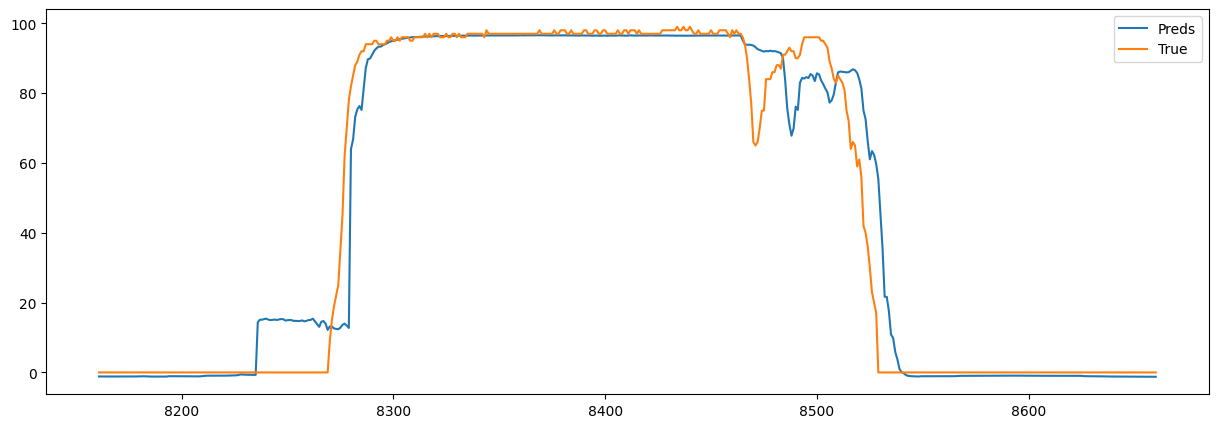

In [38]:
pd.DataFrame(np.column_stack([scalery.inverse_transform(predictions), scalery.inverse_transform(y_val)]), columns = ['Preds', 'True'])[::-1][100:100 + 500][::-1].plot(figsize = (15,5))